# Udacity Nanodegree Capstone Project
### Predicting ICU mortality based on MIMIC-III database

This is the capstone project for Udacity's machine learning project. I am interested to find out whether patient mortality could be better predicted using different medical record data instead of solely relying on severity scores such as SAPS, etc, which used logistic regression. As a binary classification problem, we have a  lot of options in machine learning algorithms. In this project, I intended to test other machine learning algorithms, such as support vector machine and random forest, optimize their performance by tuning hyperparameters,and come up with predictive models with better accuracy for ICU mortality.

The MIMIC-III is a free database, which contains over 60,000 hospital admission data for ICU patients. Medical information was aggregated from many different sources, e.g., hospital admission, ICU charted information, laboratory analysis reports, etc. Therefore, there exist many tables that documents relevant medical history about admitted patients, including lab analysis records, and charted data in ICU care. Without a background in medicine and ICU care, it is a challenge to make sense of the sophisticated data library. To make sense of the what the data actually represent, relevant literatures were collected and read by the author. To be able to gather information important to mortality prediction, structured query language (sql) scripts were first run to compile the libraries from downloaded csv files. Based on selection criteria, new sql script was written to extract necessary information for this project. The sql script was written for postgresql database and is attached to the project report.                             




### Section 2 building a benchmark model

After obtaining outlier index by running through IQR rules on selected features, the next step is to split the dataset into feature list and prediction target, i.e., hospital mortality. Information irrelevant to classification, e.g., icustay_id, was discarded. Save a copy of the data to the disk for record keeping. 
As was reported in a published paper, severity score such as saps could be fitted into logistic regression to obtain predicted mortality. The predicted mortality based on saps is coverted using 
                        Predicted Death Rate = e(Logit)/(1+e(Logit))
where Logit= 7.7631+0.0737*SAPS+0.9971*ln(SAPS+1).

In [261]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, fbeta_score,accuracy_score,precision_score, recall_score,make_scorer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedShuffleSplit,RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib


clean_df=pd.read_csv('clean_data.csv')

icustay_id=clean_df['icustay_id'].values
saps=clean_df['saps'].values
sapsii=clean_df['sapsii'].values
header=clean_df.drop(['Unnamed: 0','Unnamed: 0.1','icustay_id','hospital_expire_flag','saps','sapsii'],axis=1).columns.values.tolist()
print(header)


['male_flag', 'emergency_admission', 'ethnic_other', 'ethnic_asian', 'ethnic_hispanic', 'ethnic_black', 'ethnic_white', 'age', 'icu_los', 'hosp_los', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'spo2', 'urineoutput', 'urea', 'magnesium', 'calcium', 'aniongap', 'albumin', 'bands', 'bicarbonate', 'totalco2', 'bilirubin', 'creatinine', 'chloride', 'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc', 'tempc', 'glucose']


In [228]:
y=clean_df['hospital_expire_flag']
X=clean_df.drop(['Unnamed: 0','Unnamed: 0.1','icustay_id','hospital_expire_flag','saps','sapsii'],axis=1)
X.to_csv('X_full.csv')
X.head()

,male_flag,emergency_admission,ethnic_other,ethnic_asian,ethnic_hispanic,ethnic_black,ethnic_white,age,icu_los,hosp_los,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,tempc,glucose
0,0,1,0,1,0,0,0,61.0,3.0786,15.901389,...,181.944444,4.438889,74.246667,2.000,21.233333,136.294118,59.333333,2.955556,37.250000,86.470588
1,1,1,0,0,0,0,1,48.0,5.8884,20.081944,...,199.478261,3.662500,27.893750,1.375,15.043750,138.956522,10.000000,14.704348,37.600000,111.375000
2,1,1,1,0,0,0,0,54.0,1.3194,2.304167,...,202.250000,3.725000,36.150000,1.050,12.550000,134.666667,12.666667,6.400000,36.966667,135.000000
3,1,1,0,0,0,0,1,43.0,1.2914,3.239583,...,235.833333,3.885714,42.666667,1.150,13.450000,137.500000,10.200000,9.725000,37.188889,241.500000
4,0,0,0,0,0,0,1,47.0,2.1549,6.177083,...,146.000000,4.311765,35.420000,1.300,14.480000,139.000000,15.333333,11.053846,37.373939,112.714286


The area under curve for SAPS based logistic regression model is 0.75


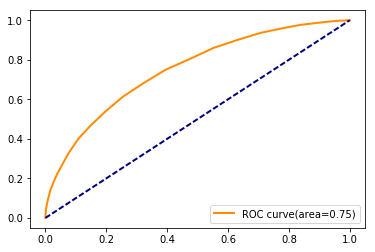

In [234]:
logit=7.7631+0.0737*saps+0.9971*np.log(saps+1)
Predicted_BM=np.exp(logit)/(1+np.exp(logit))
np.savetxt('saps.csv', Predicted_BM, delimiter=',') 
fpr_saps, tpr_saps,_=roc_curve(y,Predicted_BM)
auc_saps=auc(fpr_saps,tpr_saps)


print('The area under curve for SAPS based logistic regression model is {}'.format(round(auc_saps,2)))
plt.figure()
lw=2
plt.plot(fpr_saps,tpr_saps,color='darkorange',lw=lw,label='ROC curve(area=%0.2f)' %auc_saps)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.legend(loc='lower right')
plt.show()

Therefore, using all available data, published logistical model based on SAPS scores gave an area under curve (AUC) value of 0.75. This is a relatively good performance compared to simple guess, but the ROC curve showed that there is plenty room for improvement.

## Machine learning models and hyperparameter tuning

Let's further split the data into training and test set. I will use a training to test ratio of 75:25. I use both support vector machine and random forest classifiers for this classification project. I want to set up both SVM and RF classifiers with default settings to find out how well they perform without any parameter tuning. Because all the nan and outlying data points have been taken care of in the previous section, I would only implement preprocessing using standard scaler to bring the effect of all features within the same scale.

In [219]:
X_train, X_test, y_train, y_test =train_test_split(X,y, train_size=0.75,stratify=y)

print("Training set has {} samples".format(X_train.shape[0]))
print("Testing set has {} samples".format(X_test.shape[0]))
print("Number of total features are {}".format(X_train.shape[1]))
print("The percentage of in-hospital death is {0:.3f}".format(sum(y_test)/len(y_test)))

scaler=StandardScaler().fit(X_train)
scaler.mean_

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

Training set has 36120 samples
Testing set has 12041 samples
Number of total features are 41
The percentage of in-hospital death is 0.112


Summary statistics table. Here I intend to implement a statistics summary table for different classifiers to compare their performance after training using different methods. The statistics to be calculated include, roc_auc, accuracy, precision, recall, and f0.5 score.

In [185]:

def stat_sum(x_test,y_test,classifier_dict):
    sum_table=pd.DataFrame(data=None, index=classifier_dict.keys(),columns=['Accuracy','Precision','Recall','f-score','AUC'])
#     print(sum_table)  
    for key,classifier in classifier_dict.items():
        y_score=classifier.predict_proba(x_test)
        y_predict=classifier.predict(x_test)
        fpr, tpr,_=roc_curve(y_test,y_score[:,1])
        roc_auc=auc(fpr,tpr)
        accu=accuracy_score(y_test,y_predict)
        prec=precision_score(y_test,y_predict)
        recall=recall_score(y_test,y_predict)
        fs=fbeta_score(y_test,y_predict,0.5)
        stats=[round(elem,2) for elem in [accu,prec,recall,fs,roc_auc]]
        sum_table.loc[key]=stats
    print(sum_table)

In [186]:
set up classifiers with default parameters

SVC_native=svm.SVC(probability=True)
RF_native=RandomForestClassifier()


svcn_model=SVC_native.fit(X_train_scaled,y_train,verbose=3)
rfn_model=RF_native.fit(X_train_scaled,y_train,verbose=3)

classifier1={"SVM native": svcn_model, "Random Forest native":rfn_model}
    
stat_sum(X_test_scaled,y_test,classifier1)

                     Accuracy Precision Recall f-score   AUC
SVM native               0.93      0.83   0.43     0.7  0.92
Random Forest native     0.92      0.84   0.38    0.67   0.9


#### Fine tuning model parameters
Now, we can see that both SVM and RF classifier performed relatively well on independent test sets when compared to the benchmark model based on saps. The classifiers seemed to underperform relatively to the benchmark classifiers. This was understandable considering that many parameters have not been optimized, e.g. gamma, C,etc.  It is hopeful that the model performance will gradually improve as I fine tune the parameters for both the SVM and RF model. Here, I used grid search with 5 fold cross validation to search for optimized hyperparameter space.

In [189]:
# set up parameter dictionary for fine tuning of SVM classifier
C_range=np.logspace(-3,3,5)
gamma_range=np.logspace(-3,3,5)

parameters_svm={'C':C_range, 'gamma': gamma_range, 'class_weight': [{1:w for w in [3,9]}]}
scorer=make_scorer(fbeta_score, beta=0.5)
SVC_opt=svm.SVC(probability=True)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=20)
grid_svm=GridSearchCV(estimator=SVC_opt,param_grid=parameters_svm,scoring=scorer,n_jobs=16,iid=False,cv=cv,verbose=3)
svm_fit=grid_svm.fit(X_train_scaled,y_train)

print('SVM optimized')
svm_best=svm_fit.best_estimator_

joblib.dump(grid_svm,'grid_svm.pkl')
joblib.dump(svm_best,'svm_best.pkl')



Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed: 441.3min finished


SVM optimized


['svm_best.pkl']

In [194]:
# set up parameter dictionary for fine tuning of RF classifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


parameter_RF = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': [{1:w for w in [3,9]}]
               }

RF_opt=RandomForestClassifier()

Random_RF=RandomizedSearchCV(estimator=RF_opt,param_distributions=parameter_RF,scoring=scorer,n_jobs=16,iid=False,cv=cv, n_iter=1000,verbose=3)
RF_fit=Random_RF.fit(X_train_scaled,y_train)

RF_best=RF_fit.best_estimator_

joblib.dump(Random_RF,'Random_RF.pkl')
joblib.dump(RF_best,'RF_best.pkl')



Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed: 10.7min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed: 27.5min
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed: 51.6min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 83.3min
[Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed: 120.2min
[Parallel(n_jobs=16)]: Done 1536 tasks      | elapsed: 163.6min
[Parallel(n_jobs=16)]: Done 2016 tasks      | elapsed: 215.7min
[Parallel(n_jobs=16)]: Done 2560 tasks      | elapsed: 273.2min
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed: 337.2min
[Parallel(n_jobs=16)]: Done 3840 tasks      | elapsed: 406.0min
[Parallel(n_jobs=16)]: Done 4576 tasks      | elapsed: 485.2min
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed: 529.0min finished


['RF_best.pkl']

In [190]:
classifier2={'SVM optimized':svm_best, "RF optimized": RF_best}
stat_sum(X_test_scaled,y_test,classifier2)

              Accuracy Precision Recall f-score   AUC
SVM optimized     0.92      0.65    0.6    0.64  0.91
RF optimized      0.93       0.8    0.5    0.71  0.94


In [73]:
from sklearn.ensemble import GradientBoostingClassifier
GBT_opt = GradientBoostingClassifier()

Learn_rate=[0.01, 0.05, 0.1]
n_estimators=range(50,1000,50)
max_depth=[4, 6, 8]
min_samples_split=[2,4,8]

scorer=make_scorer(fbeta_score, beta=0.5)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=20)


GBT_parameters = {'learning_rate': Learn_rate, 'n_estimators': n_estimators,'max_depth':max_depth,'min_samples_split':min_samples_split}

grid_GBT= GridSearchCV(estimator=GBT_opt,param_grid=GBT_parameters, scoring=scorer,n_jobs=12,iid=False,cv=cv,verbose=3)

grid_fit = grid_GBT.fit(X_train_scaled, y_train)

# Get the estimator
GBT_best = grid_fit.best_estimator_


joblib.dump(grid_GBT,'grid_GBT.pkl')
joblib.dump(GBT_best,'GBT_best.pkl')



Fitting 5 folds for each of 513 candidates, totalling 2565 fits


[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   29.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed: 45.9min
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 114.7min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 266.7min
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed: 364.8min
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed: 510.5min
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed: 655.0min
[Parallel(n_jobs=12)]: Done 2565 out of 2565 | elapsed: 880.5min finished


['GBT_best.pkl']

In [191]:
classifier3={"Random Forest native": rfn_model, "GBT optimized": GBT_best}
stat_sum(X_test_scaled,y_test,classifier3)

                     Accuracy Precision Recall f-score   AUC
Random Forest native     0.92      0.84   0.38    0.67   0.9
GBT optimized            0.95      0.86   0.62    0.79  0.96


In [192]:
# set up parameter dictionary for fine tuning of SVM classifier
C_range=np.logspace(-1,4,7)
gamma_range=np.logspace(-5,0,7)


scorer=make_scorer(fbeta_score, beta=0.5)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=20)
SVC_opt=svm.SVC(probability=True)


# new scan range
parameters_svm_ns={'C':C_range, 'gamma': gamma_range, 'class_weight': [{1:w for w in [3,9]}]}

grid_svm_ns=GridSearchCV(estimator=SVC_opt,param_grid=parameters_svm_ns,scoring=scorer,n_jobs=16,iid=False,cv=cv,verbose=3)
svm_fit_ns=grid_svm_ns.fit(X_train_scaled,y_train)

print('SVM optimized')
svm_best_ns=svm_fit_ns.best_estimator_
svm_best_predict_ns=svm_best_ns.predict(X_test_scaled)

joblib.dump(grid_svm_ns,'grid_svm_ns.pkl')
joblib.dump(svm_best_ns,'svm_best_ns.pkl')


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed: 147.9min
[Parallel(n_jobs=16)]: Done 245 out of 245 | elapsed: 643.2min finished


SVM optimized


['svm_best_ns.pkl']

In [193]:
# GBT_best=joblib.load('GBT_best.pkl')
# GBT_best_predictions=GBT_best.predict(X_test_scaled)
                     
# svm_best_ns=joblib.load('svm_best_ns.pkl')                     
# svm_best_predict_ns=svm_best_ns.predict(X_test_scaled)
classifier4={"SVM native": svcn_model, "SVM optimized range1":svm_best, "SVM optimized range2":svm_best_ns}
stat_sum(X_test_scaled,y_test,classifier4)                     


                     Accuracy Precision Recall f-score   AUC
SVM native               0.93      0.83   0.43     0.7  0.92
SVM optimized range1     0.92      0.65    0.6    0.64  0.91
SVM optimized range2     0.92      0.63   0.62    0.62  0.91


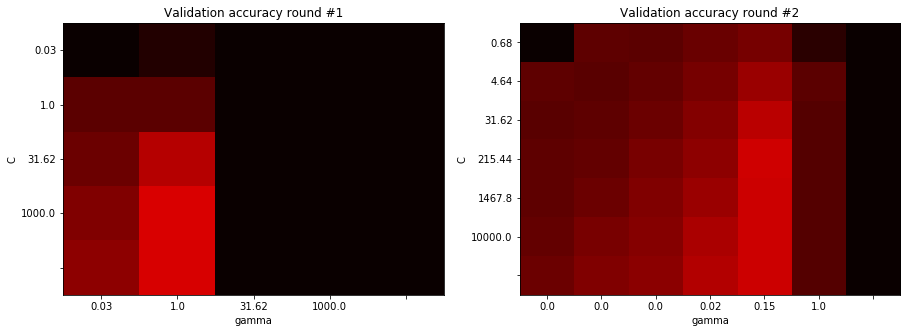

In [213]:
grid_svm=joblib.load('grid_svm.pkl')

scores1 = grid_svm.cv_results_['mean_test_score'].reshape(5, 5)
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
from matplotlib import colorbar


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

fig, (axs1,axs2)=plt.subplots(1,2,figsize=(15,5))

axs1.imshow(scores1, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
axs1.set_xlabel('gamma')
axs1.set_ylabel('C')
axs1.set_xticklabels(np.around(np.logspace(-3,3,5),decimals=2).astype('str'))
axs1.set_yticklabels(np.around(np.logspace(-3,3,5),decimals=2).astype('str'))
axs1.axis('tight')
axs1.set_title('Validation accuracy round #1')

scores2 = grid_svm_ns.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

axs2.imshow(scores2, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
axs2.set_xlabel('gamma')
axs2.set_ylabel('C')
axs2.set_xticklabels(np.around(np.logspace(-5,0,7),decimals=2).astype('str'))
axs2.set_yticklabels(np.around(np.logspace(-1,4,7),decimals=2).astype('str'))
axs2.axis('tight')
axs2.set_title('Validation accuracy round #2')
plt.show()
fig.tight_layout()
fig.savefig('SVM_search.png')



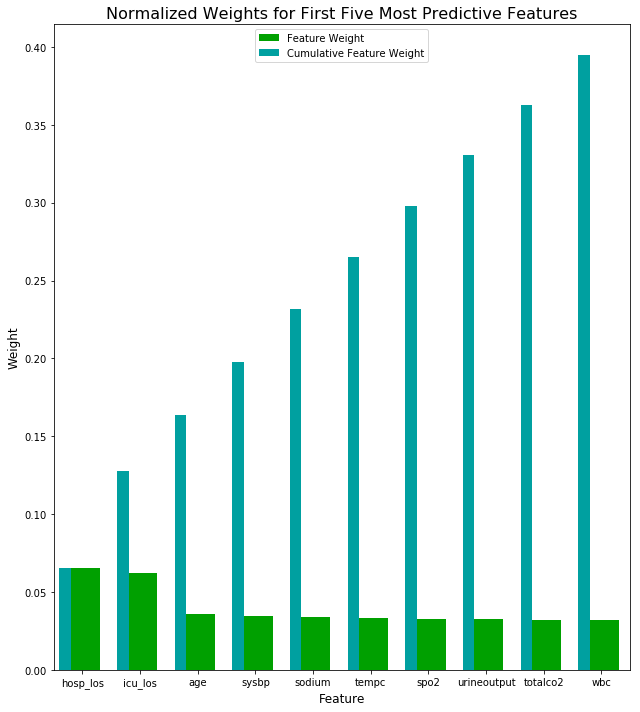

In [270]:
import visuals1 as vs
GBT_IMP=GBT_best.feature_importances_
np.savetxt('test.csv',X_train)
vs.feature_plot(GBT_IMP, X_train, y_train)

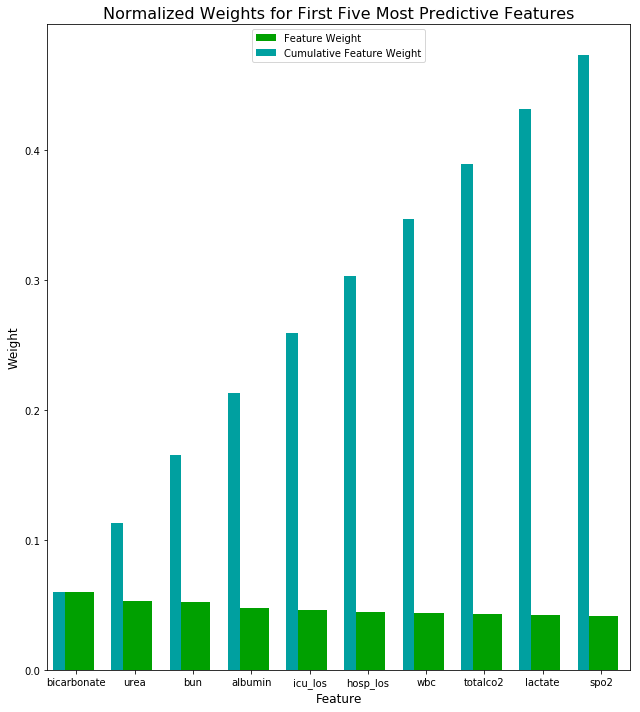

In [269]:
RF_IMP=RF_best.feature_importances_
vs.feature_plot(RF_IMP, X_train, y_train)

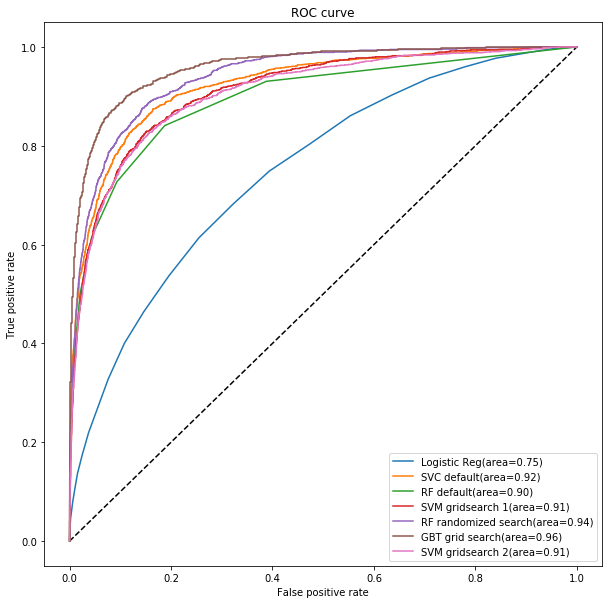

In [206]:
classifier_set={'SVC default':svcn_model,'RF default':rfn_model,'SVM gridsearch 1':svm_best,'RF randomized search':RF_best,
                'GBT grid search':GBT_best,'SVM gridsearch 2': svm_best_ns}

fig=plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_saps,tpr_saps, label='Logistic Reg(area=%0.2f)' %auc_saps)

for key, classifier in classifier_set.items():
    y_score=classifier.predict_proba(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test.values, y_score[:,1])
    auc_num=auc(fpr,tpr)
    plt.plot(fpr, tpr, label=key + '(area=%0.2f)' %auc_num)
    

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
fig.savefig('roc.png')

### Reduced model performance
Here I will select a subset of the features from GBT and RF models and retrain more compact models with those selected top features. There would be some expected degradation in model prediction performance, but the significantly reduced cost associated with collecting all biometric features would justify such performance lost.

In [259]:
from sklearn.base import clone


sum_table=pd.DataFrame(columns=['Accuracy','Precision','Recall','f-score','AUC'])
data=data={'Accuracy': 0.95,'Precision':0.86,'Recall':0.62,'f-score':0.79,'AUC':0.96}
sum_table.loc['GBT']=data

for num in [5,10]:
    X_train_reduced = X_train[X_train.columns.values[(np.argsort(GBT_IMP)[::-1])[:num]]]
    X_test_reduced = X_test[X_test.columns.values[(np.argsort(GBT_IMP)[::-1])[:num]]]
    scaler=StandardScaler().fit(X_train_reduced)
    X_train_rs=scaler.transform(X_train_reduced)
    X_test_rs=scaler.transform(X_test_reduced)
    GBT_reduced = (clone(GBT_best)).fit(X_train_rs, y_train)
    GBT_prediction_reduced=GBT_reduced.predict(X_test_rs)
    y_score=GBT_reduced.predict_proba(X_test_rs)
    y_predict=GBT_reduced.predict(X_test_rs)
    fpr, tpr,_=roc_curve(y_test,y_score[:,1])
    roc_auc=auc(fpr,tpr)
    accu=accuracy_score(y_test,y_predict)
    prec=precision_score(y_test,y_predict)
    recall=recall_score(y_test,y_predict)
    fs=fbeta_score(y_test,y_predict,0.5)
    stats=[round(elem,2) for elem in [accu,prec,recall,fs,roc_auc]]
    sum_table.loc['GBT'+str(num)]=stats
print (sum_table)


       Accuracy  Precision  Recall  f-score   AUC
GBT        0.95       0.86    0.62     0.79  0.96
GBT5       0.91       0.65    0.38     0.57  0.86
GBT10      0.93       0.77    0.50     0.70  0.93
